## Homework 9: Saxpy + CuPy Bifurcation

### Import Library

In [ ]:
import numpy as np
import sympy as sp
import cupy as cp
from numba import int32, int64, float32, float64, vectorize

import matplotlib.pyplot as plt
from plotly import graph_objs as go
from plotly import express as px
from IPython.display import Image

import time
import timeit
from threading import Thread
from multiprocessing import Pool, Process

import warnings
warnings.filterwarnings('ignore')

### Functions

In [7]:
def saxpy_func(x, y):
    return 5*x + y

@vectorize([int32(int32, int32),
            int64(int64, int64),
            float32(float32, float32),
            float64(float64, float64)], target='cuda')
def cupy_saxpy_func(x, y):
    return 5*x + y

def logistic_map_step(x, r):
    return r*x * (1 - x)

def bifurcation_map(r, m: int=1, n: int=1):
    '''
    m - number of last values
    n - number of first values
    '''
    Y = np.zeros((len(r), m))
    for i in range(len(r)):
        Y[i, 0] = np.random.random()
        for j in range(m+n-1):
            if j >= n:
                Y[i, j-n+1] = logistic_map_step(Y[i, j-n], r[i])
            else:
                Y[i, 0] = logistic_map_step(Y[i, 0], r[i])

    return Y

def parallel_bifurcation_map(r_params):
    m=200
    n=200
    Y = np.zeros(m)
    Y[0] = np.random.random()
    for j in range(m+n-1):
        if j >= n:
            Y[j-n+1] = logistic_map_step(Y[j-n], r_params)
        else:
            Y[0] = logistic_map_step(Y[0], r_params)
    return Y

@vectorize([int32(int32, int32),
            int64(int64, int64),
            float32(float32, float32),
            float64(float64, float64)], target='cuda')
def cupy_logistic_map_step(x, r):
    return r*x * (1 - x)

def cupy_bifurcation_map(r, m: int=1, n: int=1):
    '''
    m - number of last values
    n - number of first values
    '''
    Y = cp.zeros((len(r), m))
    Y[:, 0] = cp.random.random( (len(r)) )
    for j in range(m+n-1):
        if j >= n:
            Y[:, j-n+1] = cupy_logistic_map_step(Y[:, j-n], r)
        else:
            Y[:, 0] = cupy_logistic_map_step(Y[:, 0], r)

    return Y

### Task 9.1

> **Difference between cupy and numpy:** <br>
Numpy works using CPU. Numpy is good for small tasks, because it does not require data transfer between devices. However, performance is limited by processor resources. You can use Numpy for tasks, where the data transfer between the CPU and GPU will take longer than the computation itself.  <br>
CuPy works using GPU. CuPy is good for big tasks, because it uses thousands of GPU cores for parallel computing. You can use CuPy for tasks with large data arrays (e.g. >10⁶ elements) and if tasks are processor intensive (linear algebra, data transformations). <br>

> **How does cupy handle data transfers between CPU and GPU?**
1. Data transfer from CPU to GPU <br>
When you create a cupy.array object from a numpy.array, CuPy copies the data from random access memory (RAM) to the GPU's VRAM. This process is called host copying.
2. Task implementation on GPU
3. GPU --> CPU <br>
When you need to get the result on the CPU (for example, for rendering or saving), you call the cp.asnumpy method, which copies the data from VRAM back to RAM.

### Task 9.2

In [81]:
n = 100000000
x = cp.random.randn(n)
y = cp.random.randn(n)
result = cupy_saxpy_func(x, y)
result

### Task 9.3

In [115]:
array_size = np.arange(10**7, 10**8+1, 10**7)
numpy_time, cupy_time = np.zeros(len(array_size)), np.zeros(len(array_size))

for i, size in enumerate(array_size):
  x = np.random.randn(int(size))
  y = np.random.randn(int(size))
  start_time = time.time()
  saxpy_func(x, y)
  end_time = time.time()
  numpy_time[i] = end_time - start_time

  x = cp.array(x)
  y = cp.array(y)
  start_time = time.time()
  cupy_saxpy_func(x, y)
  end_time = time.time()
  cupy_time[i] = end_time - start_time


In [136]:
fig = go.Figure()

fig.add_trace(go.Histogram(histfunc= 'max',
                            x = list(map(str, np.arange(1, 11, 1))),
                            y = numpy_time,
                            name = 'NumPy',
                            ))
fig.add_trace(go.Histogram(histfunc= 'max',
                            x = list(map(str, np.arange(1, 11, 1))),
                            y = cupy_time,
                            name = 'CuPy',
                            ))

fig.update_layout(font_size = 25,
                    font_color='black',
                    title = "Model Evaluation",
                    plot_bgcolor = 'rgba(250,250,250,1)',
                    width = 1400,
                    height = 700,
                    # LEGEND
                    legend_title = "Models",
                    legend_font_size = 25,
                    legend_x = 1.02,
                    legend_y = 1,
                    #legend_bordercolor = 'black',
                    #legend_borderwidth = 1,
                    legend_itemsizing = 'trace',
                    legend_itemwidth=100,
                    # X-axis
                    xaxis_title = f"Size of arrays, 10<sup>7</sup>",
                    #xaxis_nticks = 7,
                    xaxis_ticklen = 16,
                    xaxis_tickwidth = 3,
                    xaxis_ticks = 'outside',
                    # Y-axis
                    yaxis_title = "Computation time",
                    #yaxis_nticks = 10,
                    yaxis_ticklen = 16,
                    yaxis_tickwidth = 3,
                    yaxis_ticks = 'outside'
                    )

fig.add_shape(type="rect",
                xref="paper",
                yref="paper",
                x0=0,
                y0=0,
                x1=1.0,
                y1=1.0,
        line=dict(
            color="black",
                width=1,))
fig.layout.font.family = 'sans-serif'

fig.show()

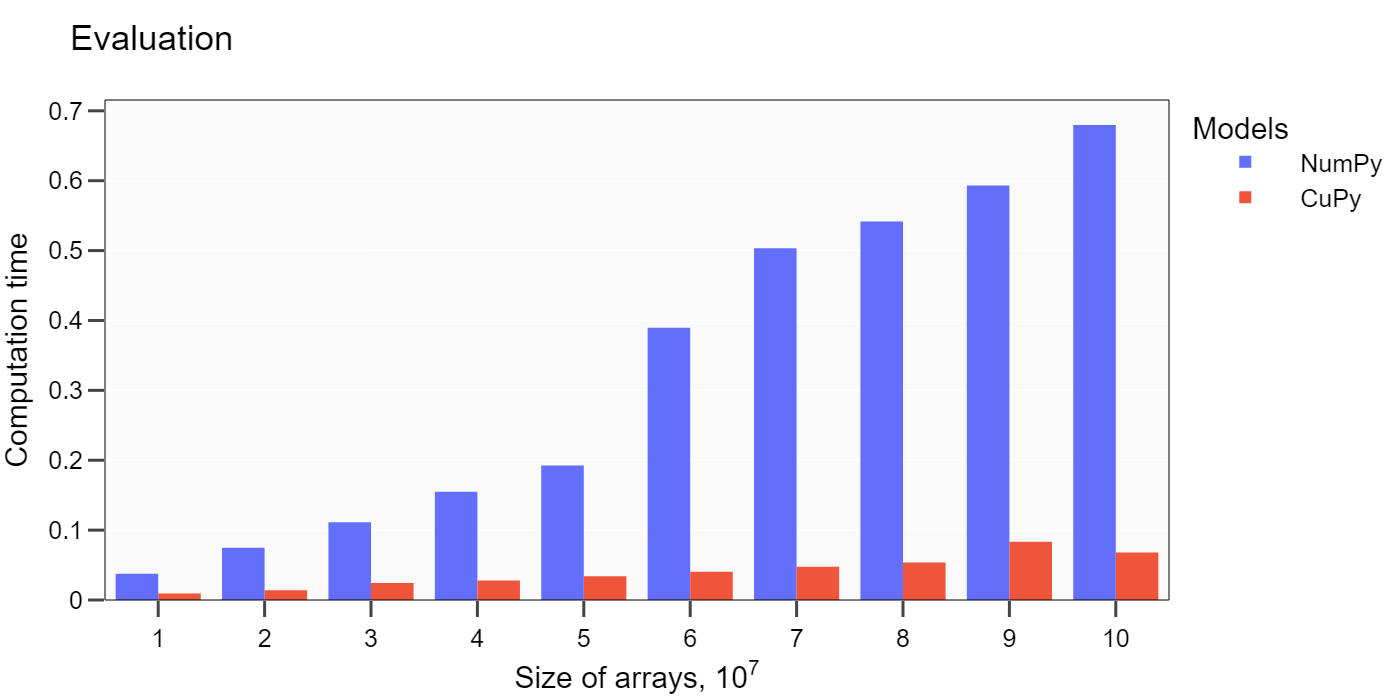

In [17]:
Image(open("HW_9_evaluation.png", 'rb').read())

### Task 9.4

#### With NumPy

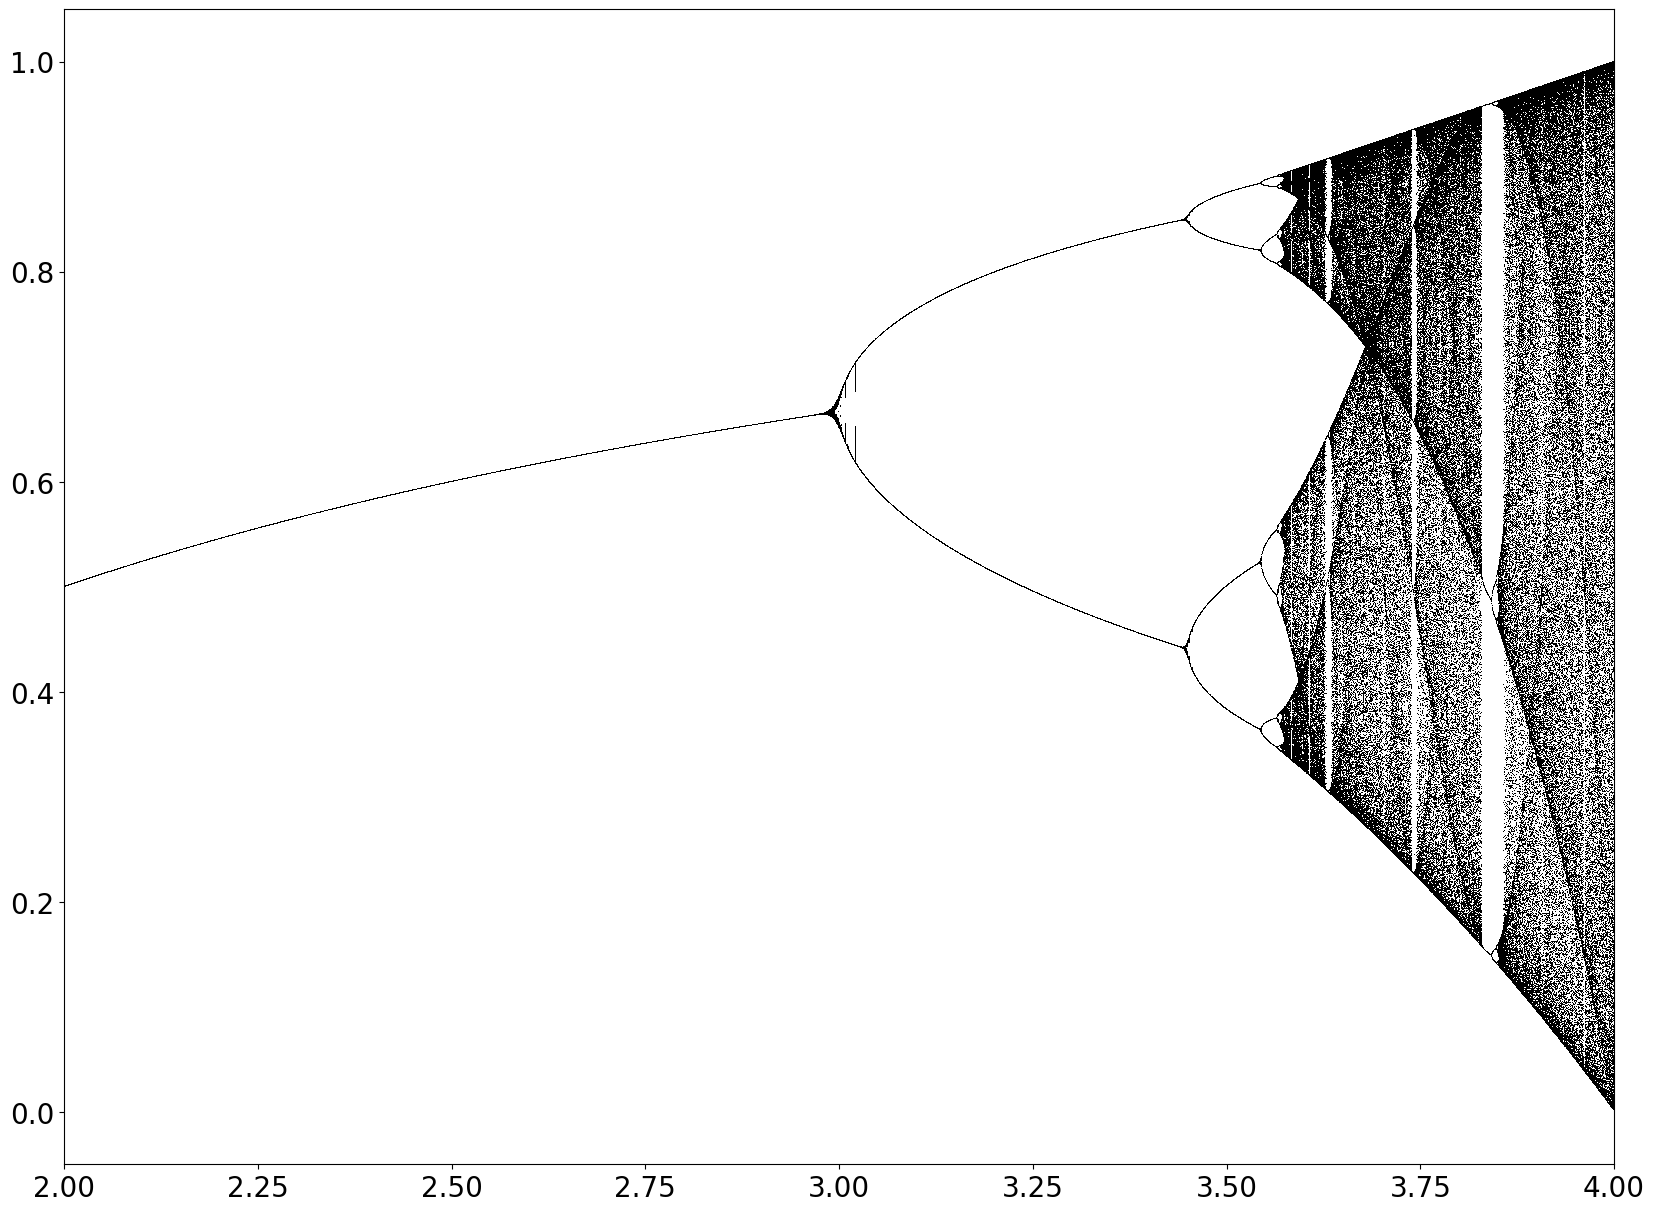

In [78]:
n = 10001
r_params = np.linspace(1, 4, n)
Y = bifurcation_map(
    r=r_params,
    m=200,
    n=200,
)
fig = plt.figure(figsize=[20, 15], )
for i, r in enumerate(r_params):
    plt.plot(np.ones(Y.shape[1])*r_params[i], Y[i], ls='', marker=',', color='black')

plt.xlim([2, 4])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

#### With CuPy

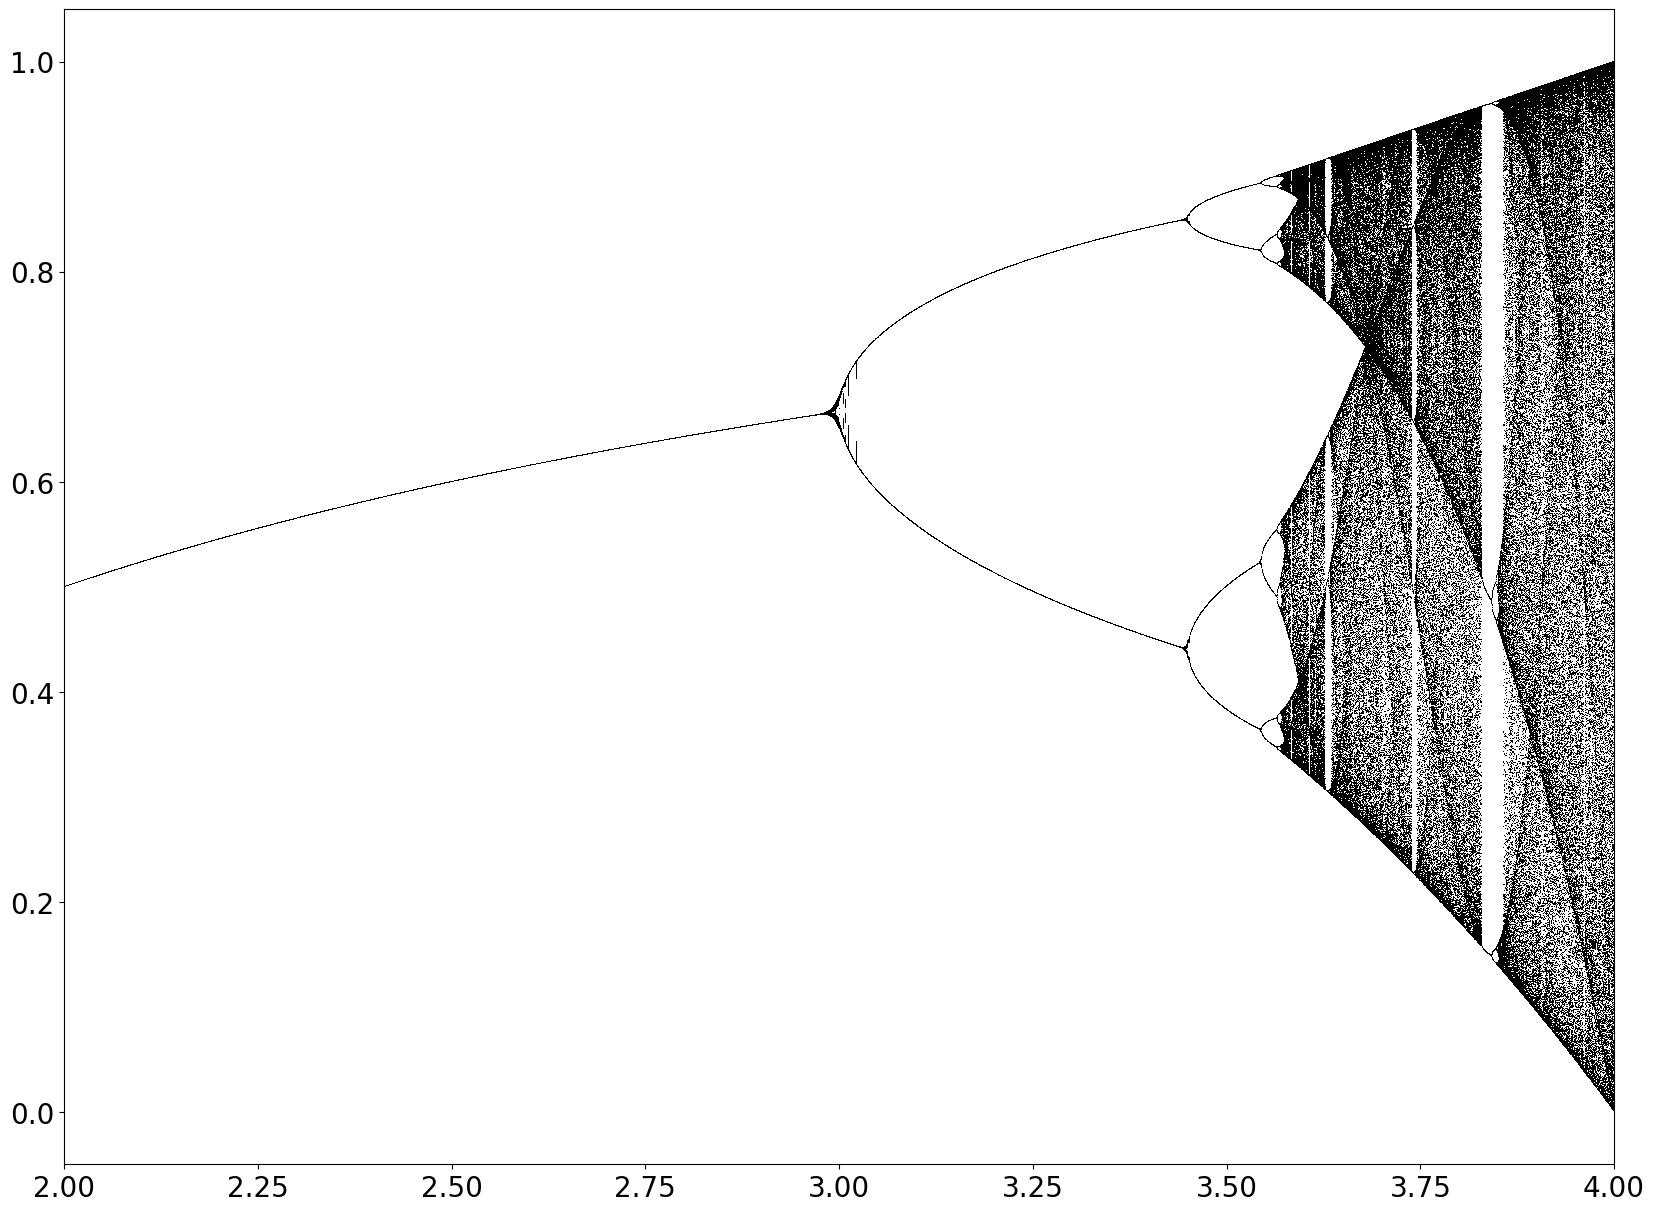

In [79]:
r_params = cp.linspace(1, 4, 10001)
Y_cupy = cupy_bifurcation_map(
    r=r_params,
    m=200,
    n=200,
)
Y_numpy = Y_cupy.get()
fig = plt.figure(figsize=[20, 15], )
for i, r in enumerate(r_params):
    plt.plot(np.ones(Y_numpy.shape[1])*r_params.get()[i], Y_numpy[i], ls='', marker=',', color='black')

plt.xlim([2, 4])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

### Task 9.5

In [3]:
n = np.arange(10**4, 10**5+1, 10**4)

#### CPU

In [10]:
cpu_time = np.zeros(len(n))
for i in range(len(n)):
  r_params = np.linspace(1, 4, n[i])

  start_time = time.time()
  Y = bifurcation_map(
      r=r_params,
      m=200,
      n=200,
  )
  end_time = time.time()

  cpu_time[i] = end_time - start_time


#### Parallel

In [6]:
parallel_time = np.zeros(len(n))
for i in range(len(n)):
  r_params = np.linspace(1, 4, n[i])

  start_time = time.time()
  with Pool(processes=2) as pool:
    pool.map(func=parallel_bifurcation_map, iterable=r_params)
  end_time = time.time()

  parallel_time[i] = end_time - start_time


#### GPU

In [8]:
gpu_time = np.zeros(len(n))
for i in range(len(n)):
  r_params = cp.linspace(1, 4, n[i])

  start_time = time.time()
  Y_cupy = cupy_bifurcation_map(
      r=r_params,
      m=200,
      n=200,
  )
  end_time = time.time()

  gpu_time[i] = end_time - start_time


#### Graph

In [11]:
fig = go.Figure()

fig.add_trace(go.Histogram(histfunc= 'max',
                            x = list(map(str, np.arange(1, 11, 1))),
                            y = cpu_time,
                            name = 'CPU',
                            ))
fig.add_trace(go.Histogram(histfunc= 'max',
                            x = list(map(str, np.arange(1, 11, 1))),
                            y = parallel_time,
                            name = 'Parallel',
                            ))
fig.add_trace(go.Histogram(histfunc= 'max',
                            x = list(map(str, np.arange(1, 11, 1))),
                            y = gpu_time,
                            name = 'GPU',
                            ))

fig.update_layout(font_size = 25,
                    font_color='black',
                    title = "Model Evaluation",
                    plot_bgcolor = 'rgba(250,250,250,1)',
                    width = 1400,
                    height = 700,
                    # LEGEND
                    legend_title = "Models",
                    legend_font_size = 25,
                    legend_x = 1.02,
                    legend_y = 1,
                    #legend_bordercolor = 'black',
                    #legend_borderwidth = 1,
                    legend_itemsizing = 'trace',
                    legend_itemwidth=100,
                    # X-axis
                    xaxis_title = f"Size of arrays, 10<sup>4</sup>",
                    #xaxis_nticks = 7,
                    xaxis_ticklen = 16,
                    xaxis_tickwidth = 3,
                    xaxis_ticks = 'outside',
                    # Y-axis
                    yaxis_title = "Computation time",
                    #yaxis_nticks = 10,
                    yaxis_ticklen = 16,
                    yaxis_tickwidth = 3,
                    yaxis_ticks = 'outside'
                    )

fig.add_shape(type="rect",
                xref="paper",
                yref="paper",
                x0=0,
                y0=0,
                x1=1.0,
                y1=1.0,
        line=dict(
            color="black",
                width=1,))
fig.layout.font.family = 'sans-serif'

fig.show()

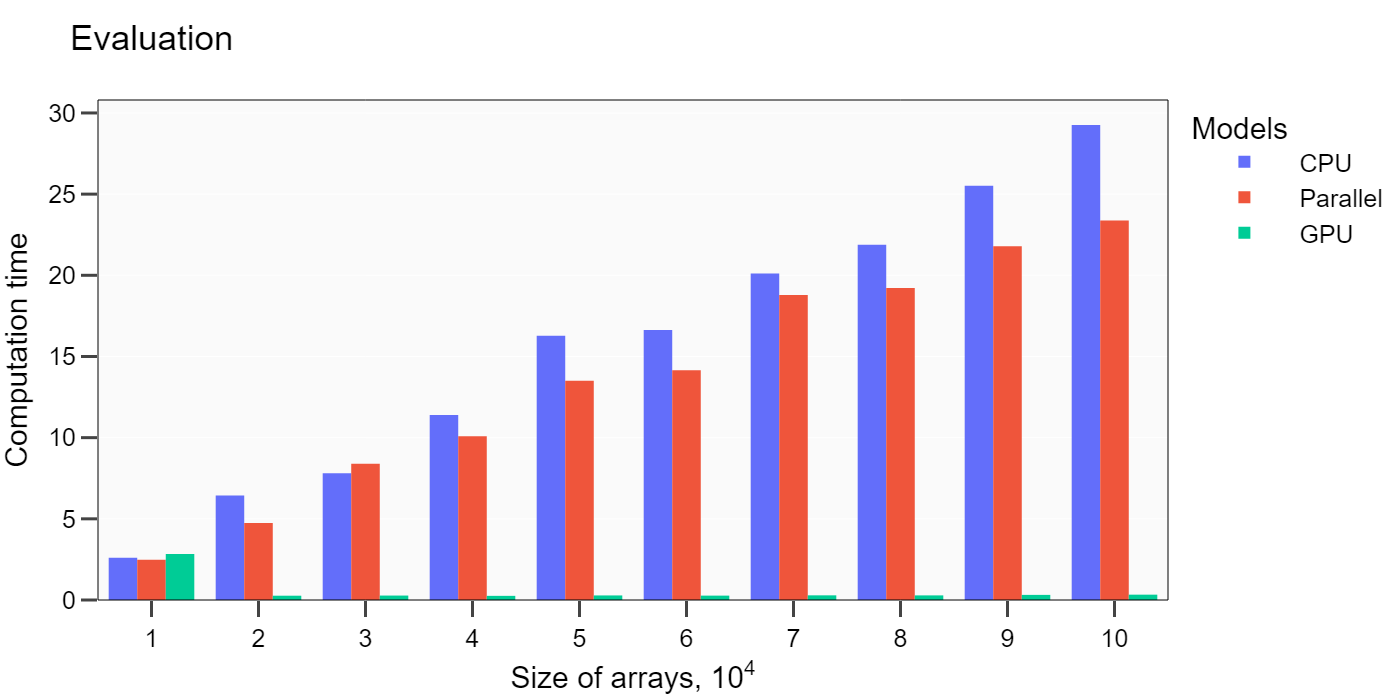

In [16]:
Image(open("HW_9_evaluation1.png", 'rb').read())